# SuperVoice dVAE evaluation
This notebook provides tools for dVAE evaluation

In [1]:
# Base
import itertools
from glob import glob
from tqdm import tqdm
from IPython.display import Audio, display
import fsspec
import os

# ML
import torch
import torch.nn.functional as F
from torch.utils.data import DistributedSampler, DataLoader
from torch.utils.tensorboard import SummaryWriter

# Local
from vocoder.model import Generator
from dvae.model import DiscreteVAE
from utils.misc import plot_specgram, plot_waveform
from utils.audio import spectogram, load_mono_audio
from train_config import config

### Environment

In [2]:
# Parameters
device = torch.device('cuda:0')
checkpoint = "./checkpoints/dvae_dvae_2gelu.pt"
checkpoint_vocoder = "./checkpoints/vocoder_sr_24khz.pt"

# Device and Model
dvae = DiscreteVAE(
    # Base mel spec parameters
    positional_dims=1,
    channels=config.audio.num_mels,

    # Number of possible tokens
    num_tokens=config.dvae.tokens,

    # Architecture
    codebook_dim=config.dvae.codebook_dim,
    hidden_dim=config.dvae.hidden_dim,
    num_resnet_blocks=config.dvae.num_resnet_blocks,
    kernel_size=config.dvae.kernel_size,
    num_layers=config.dvae.num_layers,
    use_transposed_convs=False,
).to(device)
generator = Generator(config).to(device)

# Load checkpoint
data = torch.load(checkpoint)
dvae.load_state_dict(data['dvae'])
data = torch.load(checkpoint_vocoder)
generator.load_state_dict(data['generator'])

# Switch to eval
dvae.eval()
generator.eval()
generator.remove_weight_norm()

/home/steve/miniconda/envs/gym/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Removing weight norm...


# Evaluation

In [3]:
# Custom file
from ipywidgets import FileUpload
upload = FileUpload(multiple=False)
upload

FileUpload(value=(), description='Upload')

/home/steve/miniconda/envs/gym/lib/python3.10/site-packages/torch/functional.py:660: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:874.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


decode
tensor([[176, 336, 195, 195, 195, 261,  73, 195, 261, 293, 261, 195,  73,   9,
         366,  32, 117,  73,  73, 293,  73, 195,  73, 261, 293,  73,  73, 195,
         261, 261, 261, 293, 195, 195,  73,  73,  73,  73, 195, 261, 261, 261,
         109, 195, 366,  32,  73,  73, 261, 261, 261, 261, 293, 195, 195,  73,
         195, 195, 261, 261, 261, 195, 195,   2, 261, 261, 261, 261, 261, 195,
         195, 195, 261, 261,  31, 366, 195, 366, 276, 276, 366, 366, 117, 293,
         261, 261, 261, 261, 293, 195, 195, 366, 117, 366, 366, 195, 195,  73,
          73, 195, 195, 366, 195,   2, 261, 261, 261, 261, 261, 261, 261, 261,
         261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 413, 261, 261,
         195, 195,  73, 184, 366,   9,   9,  73,  73,  73, 293, 293, 195, 195,
         261, 261, 261, 261, 261, 413, 195, 195, 195,  73,  73, 261, 261, 293,
         195, 195, 261, 293, 366, 195, 195,  73, 293, 293, 195, 195, 366, 153,
           9,  73, 261, 261, 261, 413,   2, 2

/home/steve/miniconda/envs/gym/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
tensor([[[ 17308.9082,  -3826.4966,  14121.4092,  ...,   5758.8462,
            3756.9604,   9069.6660],
         [ 28687.6543,  30273.0078,  39538.2461,  ...,  44937.0078,
           30552.5684,  31130.8926],
         [  4999.6812,  10275.9277,  12695.4404,  ...,  14639.7891,
            5246.4854,   7168.2222],
         ...,
         [-20872.4062, -11153.7324, -47075.7930,  ..., -42452.7031,
          -28516.6035, -51121.8906],
         [ 20605.3262,  47918.4648,  22022.0117,  ...,  35853.6719,
           23705.3438,  22601.9141],
         [ 21151.4922,   -523.5064,   9553.7119,  ...,  21150.5039,
           22706.0977, -13901.0771]]], device='cuda:0')
tensor([[[  8170.1045,  22797.9961,  -5504.4214,  ...,   4390.4653,
           16307.0127,    837.1467],
         [  9497.9688,  16320.3799,   -543.6891,  ...,  10432.5830,
            9801.3164,  -2854.1753],
         [ 15028.6445,  33348.3633,  11344.1338,  ...,  20904.8047,
          

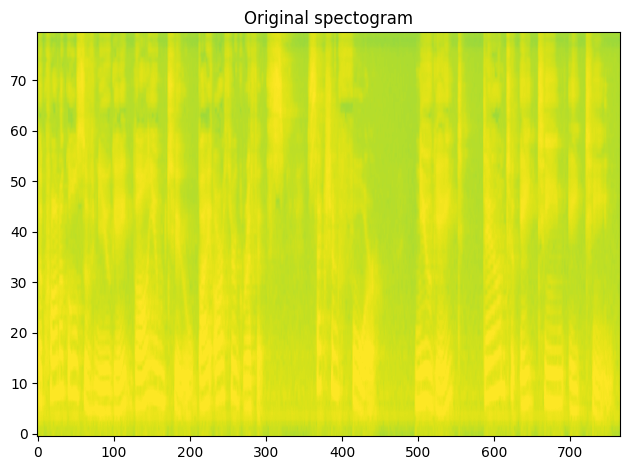

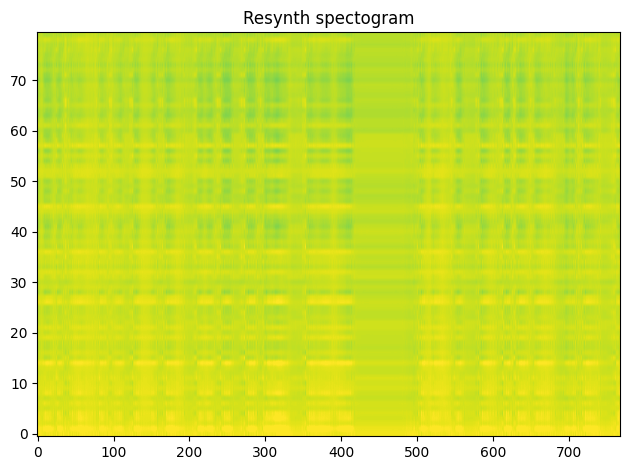

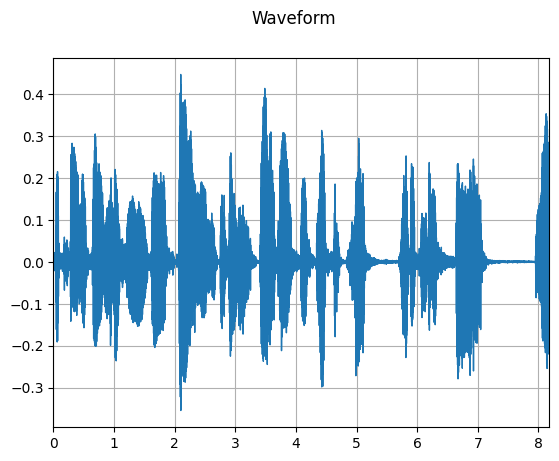

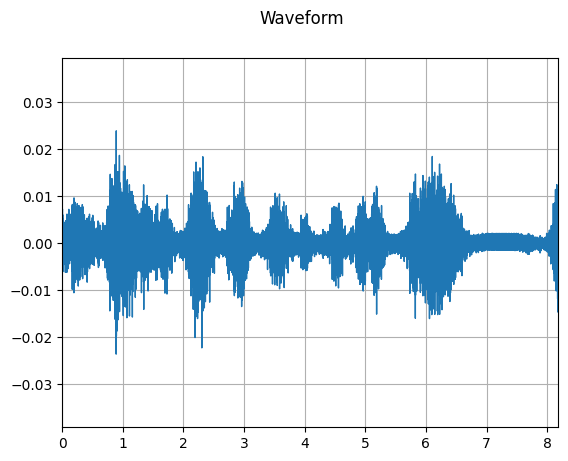

In [4]:
# Load
if len(upload.value) == 1:
    with open("eval_vocoder.out", "w+b") as i:
        i.write(upload.value[0].content)
    test = load_mono_audio("eval_vocoder.out", config.audio.sample_rate)
else:
    test = load_mono_audio("./external_datasets/lj-speech-1.1/wavs/LJ002-0001.wav", config.audio.sample_rate)
spec = spectogram(test, config.audio.n_fft, config.audio.num_mels, config.audio.hop_size, config.audio.win_size, config.audio.sample_rate)

# Generate
codes = dvae.get_codebook_indices(spec.unsqueeze(0).to(device) / config.dvae.log_mel_multiplier)
codes_spec, codes_spec_2 = dvae.infer(spec.unsqueeze(0).to(device) / config.dvae.log_mel_multiplier)
codes_spec = codes_spec * config.dvae.log_mel_multiplier
resynth = generator(codes_spec).detach().cpu().squeeze(0)
codes_spec = codes_spec.detach().cpu().squeeze(0)

print(codes.shape, spec.shape, codes_spec.shape)

print(codes)
print(spec)
print(codes_spec)
print(codes_spec_2)

# resynth = dvae generator(spec.unsqueeze(0).to(device)).detach().cpu().squeeze(0)
# resynth_spec = spectogram(resynth, config.audio.n_fft, config.audio.num_mels, config.audio.hop_size, config.audio.win_size, config.audio.sample_rate).squeeze(0)

# Source
plot_specgram(spec, title="Original spectogram")
plot_specgram(codes_spec.cpu(), title="Resynth spectogram")
plot_waveform(test.unsqueeze(0),xlim=(0,len(test) / config.audio.sample_rate))
plot_waveform(resynth,xlim=(0,len(test) / config.audio.sample_rate))
display(Audio(data=test, rate=config.audio.sample_rate))
display(Audio(data=resynth, rate=config.audio.sample_rate))